In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

In [2]:
data = pd.read_csv('data.csv')

In [3]:
features = ['open', 'high', 'low', 'close', 'volume']

In [4]:
features1 = ['datetime','signal','close']

In [5]:
X = data[features]
y = data[features1]

In [6]:
y.head()

,datetime,signal,close
0,2020-07-16,none,9130.11
1,2020-07-17,none,9154.29
2,2020-07-18,buy,9175.85
3,2020-07-19,none,9212.87
4,2020-07-20,none,9161.05


In [7]:
def calculate_donchian_channel(high, low, close, n=55, m=20):
    upper_channel = high.rolling(window=n).max()
    lower_channel = low.rolling(window=m).min()
    middle_channel = (upper_channel + lower_channel) / 2
    return upper_channel, lower_channel, middle_channel

def calculate_true_range(high, low, prev_close):
    tr1 = high - low
    tr2 = abs(high - prev_close)
    tr3 = abs(low - prev_close)
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return true_range

def calculate_atr(true_range, n=20):
    atr = true_range.ewm(span=n, adjust=False).mean()
    return atr

def calculate_position_size(account_funds, atr):
    position_size = account_funds * 0.01 / atr
    return position_size

In [8]:
def turtle_trading_signals(data):
    signals = pd.DataFrame(index=data.index, columns=['signal'])
    signals['signal'] = 'none'
    positions_opened = 0  # Keep track of the number of positions opened
    last_buy_price = 0  # Keep track of the last buy price
    
    prev_close = data['close'].shift(1)
    high = data['high']
    low = data['low']
    close = data['close']
    
    upper_channel, lower_channel, middle_channel = calculate_donchian_channel(high, low, close)
    true_range = calculate_true_range(high, low, prev_close)
    atr = calculate_atr(true_range)
    
    for i in range(1, len(data)):
        if positions_opened < 4:  # Check if max positions limit is reached
            if close[i] > upper_channel[i-1]:  # Buy signal
                signals.iloc[i] = 'buy'
                positions_opened += 1
                last_buy_price = close[i]
            elif close[i] < lower_channel[i-1]:  # Sell signal
                signals.iloc[i] = 'sell'
                positions_opened = 0  # Reset position count when selling
            elif close[i] > last_buy_price + 0.5 * atr[i]:  # Add position condition
                signals.iloc[i] = 'buy'
                positions_opened += 1
        else:
            if close[i] < lower_channel[i-1]:  # Exit condition based on Donchian Channel
                signals.iloc[i] = 'sell'
                positions_opened = 0  # Reset position count when selling
            elif close[i] < last_buy_price - 2 * atr[i]:  # Exit condition based on unfavorable price trend
                signals.iloc[i] = 'sell'
                positions_opened = 0  # Reset position count when selling
    
    return signals

In [9]:
signals = turtle_trading_signals(data)

In [10]:
y.head()

,datetime,signal,close
0,2020-07-16,none,9130.11
1,2020-07-17,none,9154.29
2,2020-07-18,buy,9175.85
3,2020-07-19,none,9212.87
4,2020-07-20,none,9161.05


In [11]:
signals['datetime'] = y['datetime']
signals['close'] = y['close']

In [12]:
signals.head()

,signal,datetime,close
0,none,2020-07-16,9130.11
1,buy,2020-07-17,9154.29
2,buy,2020-07-18,9175.85
3,buy,2020-07-19,9212.87
4,buy,2020-07-20,9161.05


In [13]:
accuracy = (signals['signal'] == y['signal']).mean()
print("Accuracy:", accuracy)

Accuracy: 0.7240641711229947


In [14]:
# Compute confusion matrix
cm = confusion_matrix(y['signal'], signals['signal'])

print("Confusion Matrix:")
print(cm)

# Generate classification report
report = classification_report(y['signal'], signals['signal'])

print("Classification Report:")
print(report)

Confusion Matrix:
[[  4  67   7]
 [ 75 673  23]
 [  5  81   0]]
Classification Report:
              precision    recall  f1-score   support

         buy       0.05      0.05      0.05        78
        none       0.82      0.87      0.85       771
        sell       0.00      0.00      0.00        86

    accuracy                           0.72       935
   macro avg       0.29      0.31      0.30       935
weighted avg       0.68      0.72      0.70       935



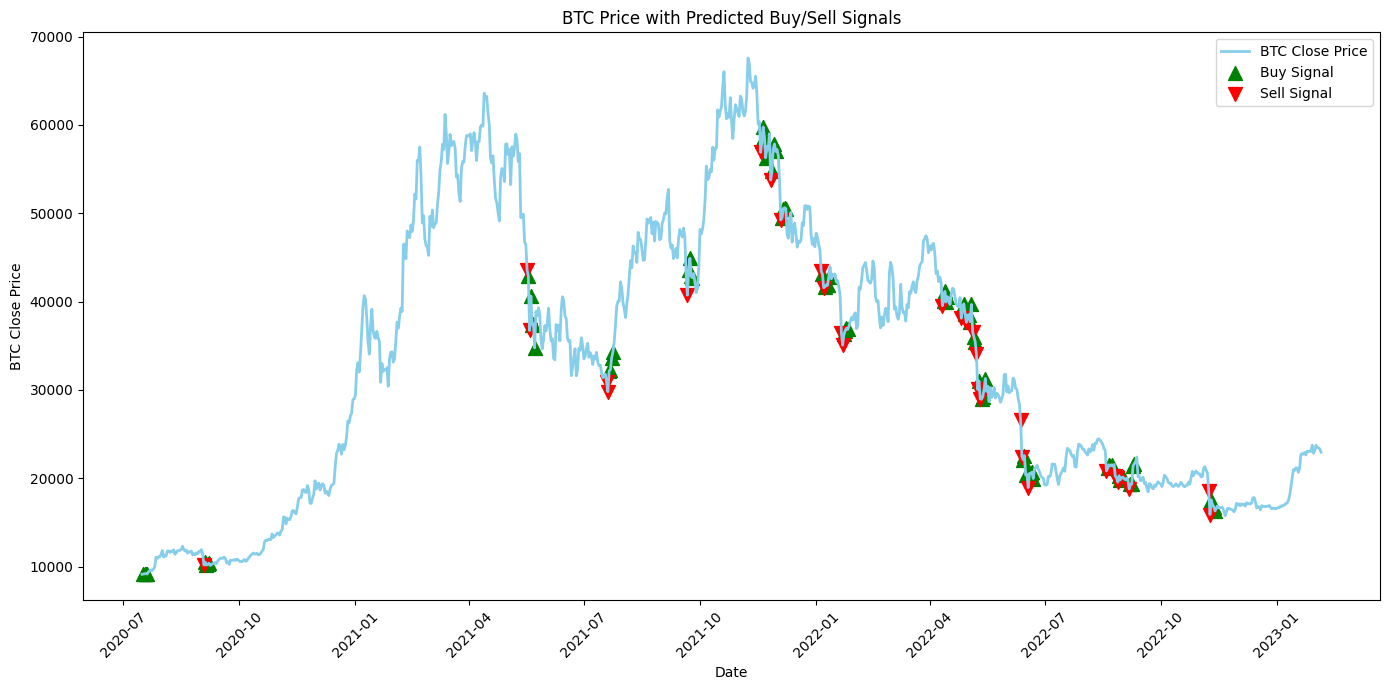

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime is in the correct format
data['datetime'] = pd.to_datetime(data['datetime'])

plt.figure(figsize=(14, 7))
plt.plot(data['datetime'], data['close'], label='BTC Close Price', color='skyblue', linewidth=2)

# Adjust the conditions to match the labels
# Highlight buy signals
buy_signals = signals[signals['signal'] == 'buy']  # Assuming 0 represents 'buy'
plt.scatter(buy_signals['datetime'], buy_signals['close'], label='Buy Signal', marker='^', color='green', alpha=1, s=100)

# Highlight sell signals
sell_signals = signals[signals['signal'] == 'sell']  # Assuming 1 represents 'sell'
plt.scatter(sell_signals['datetime'], sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1, s=100)

plt.title('BTC Price with Predicted Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()